In [21]:
pip install rouge

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [22]:
!pip install transformers[torch] datasets -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


from google.colab import drive
drive.mount('/content/drive')

In [23]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
import json
json_file_path = '/kaggle/input/dldata/Final data All Week.json'

with open(json_file_path, 'r') as file:
    dataset = json.load(file)


In [26]:
def load_image(image_path, base_path='/kaggle/input/dldata/all_slides - Copy'):
    full_path = os.path.join(base_path, image_path)
    image = Image.open(full_path).convert('RGB')  # Ensure RGB format
    return image


In [27]:
import pandas as pd
df = pd.read_json(json_file_path)
print(df.head())


                                         instruction  \
0  What operations were mentioned in last week's ...   
1         What was the focus of last week's lecture?   
2  What did last week's lecture mention about noi...   
3   What topics were covered in last week's lecture?   
4  What are some possible reasons for noise in im...   

                                            response                category  \
0  Last week's lecture mentioned operations such ...  information_extraction   
1  The focus of last week's lecture was on discus...               closed_qa   
2  Last week's lecture briefly mentioned the pres...               closed_qa   
3  Last week's lecture covered image representati...              general_qa   
4  Possible reasons for noise in images include l...  information_extraction   

   week  page                                            context  
0     3     2  The transcript discusses the operations covere...  
1     3     2  The transcript provides informati

## Sample Visualization

In [28]:
def construct_image_path(sample, base_path='/kaggle/input/dldata/all_slides - Copy'):
    image_file_name = f"week_{str(sample['week']).zfill(2)}_page_{str(sample['page']).zfill(3)}.png"
    return os.path.join(base_path, image_file_name)


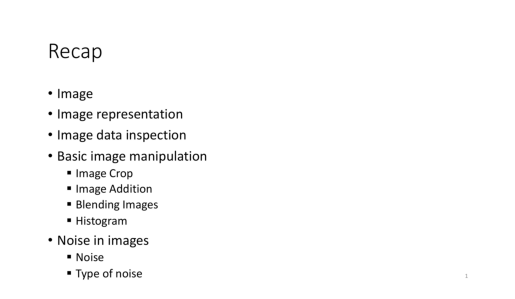

Question: What was the focus of last week's lecture?
Answer: The focus of last week's lecture was on discussing image representation, data inspection, and basic image manipulation operations.


In [29]:
import os
sample_index = 1
sample = dataset[sample_index]

image_path = construct_image_path(sample)

image = Image.open(image_path).convert('RGB')

plt.imshow(image)
plt.axis('off')
plt.show()
print("Question: {}".format(sample['instruction']))
print("Answer: {}".format(sample['response']))


In [30]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

## Build Data-loader

In [31]:
import torch
from PIL import Image
import os
from transformers import CLIPProcessor, CLIPModel, BlipProcessor, BlipImageProcessor

# Initialize the processors and models
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, text_processor, image_processor):
        self.data = data
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 224  # Ensure this matches CLIP's requirements
        self.image_width = 224

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        instruction = sample['instruction']
        response = sample['response']
        image_path = self.construct_image_path(sample)
        image = Image.open(image_path).convert('RGB')
        image = image.resize((self.image_width, self.image_height))

        # Process image with CLIP-specific processor for correct tokenization and normalization
        image_encoding = clip_processor(images=image, return_tensors="pt")

        # Process text with BLIP text processor
        text_encoding = text_processor(text=instruction, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")

        # Encode labels using the BLIP tokenizer
        labels = text_processor.tokenizer.encode(response, max_length=self.max_length, padding="max_length", truncation=True, return_tensors='pt')[0]

        return {
            'input_ids': text_encoding['input_ids'].squeeze(),
            'attention_mask': text_encoding['attention_mask'].squeeze(),
            'pixel_values': image_encoding['pixel_values'].squeeze(),
            'labels': labels
        }

    def construct_image_path(self, sample):
        base_path = '/kaggle/input/dldata/all_slides - Copy'
        image_file_name = f"week_{str(sample['week']).zfill(2)}_page_{str(sample['page']).zfill(3)}.png"
        return os.path.join(base_path, image_file_name)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

In [32]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Create VQADataset instances for training and validation
train_vqa_dataset = VQADataset(train_dataset, text_processor, image_processor)
val_vqa_dataset = VQADataset(val_dataset, text_processor, image_processor)


In [33]:
train_vqa_dataset[0]

{'input_ids': tensor([ 101, 2054, 2024, 2070, 3145, 2685, 4953, 1996, 5197, 1998, 5097, 1997,
         3746, 6364, 2004, 2649, 1999, 1996, 3793, 1029,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'pixel_values': tensor([[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          ...,
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],
 
         [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
    

In [34]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=16,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=16,
                            shuffle=False)

In [35]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([16, 32])
attention_mask torch.Size([16, 32])
pixel_values torch.Size([16, 3, 224, 224])
labels torch.Size([16, 32])


## Build Model

In [36]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" )
model.to(device)

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [37]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] how does the dimensionality of data impact machine learning algorithms? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] the dimensionality of data affects machine learning algorithms by influencing their complexity, performance, and ability to generalize from the training data to unseen examples, with [SEP]


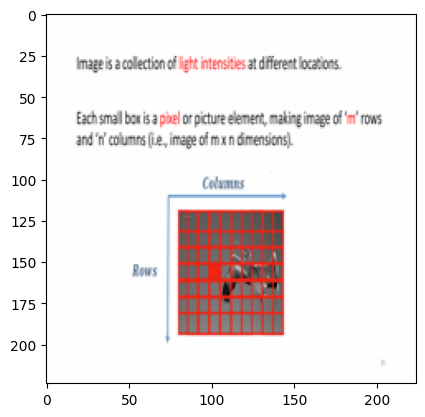

In [38]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

## Model Training

In [39]:
model.train()
for epoch in range(10):
    print(f"Epoch: {epoch}")
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Loss:", sum(total_loss))

Epoch: 0


  0%|          | 0/540 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 1967.4081168174744
Epoch: 1


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 1229.0007283687592
Epoch: 2


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 923.0211653709412
Epoch: 3


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 715.8846519589424
Epoch: 4


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 564.7740097045898
Epoch: 5


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 422.90998017787933
Epoch: 6


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 308.0842525064945
Epoch: 7


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 226.75213693082333
Epoch: 8


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 165.3021023273468
Epoch: 9


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 118.14732511341572


## Inference

Question:  what is the speaker ' s opinion about perceiving the difference?


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer:  the speaker acknowledges the importance of increasing the parameter of the convolutional layer, suggesting
Actual Answer:  the speaker acknowledges that it ' s very difficult to perceive the difference.


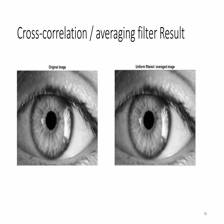

###################################################################
Question:  how are the scales ' sk ' determined for each default box?
Predicted Answer:  the scales of the perceptron algorithm may vary in terms of computational complexity, where it
Actual Answer:  the scales ' sk ' are computed using a formula that takes into account the size of the feature map and the desired number of default boxes to cover various


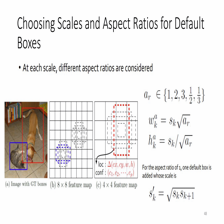

###################################################################
Question:  what is an fcn and what does it do?
Predicted Answer:  an fcn ( fcn ) can be adapted for deeper convolutional layers by
Actual Answer:  a fully convolutional network ( fcn ) is a type of neural network designed for semantic image segmentation. it processes images on a


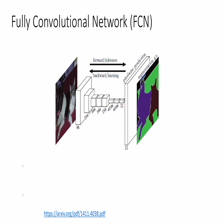

###################################################################
Question:  how might one mitigate the occurrence of spurious patterns in hierarchical clustering results?
Predicted Answer:  one limitation of hierarchical clustering could involve the sensitivity of the euclidean distance metric, where the relationships
Actual Answer:  mitigating spurious patterns in hierarchical clustering results can involve carefully selecting appropriate distance measures, preprocessing data to remove noise, and valid


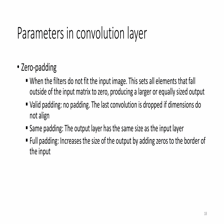

###################################################################
Question:  how does the transcript convey the concept of ' tasking ' in relation to the use of robots?
Predicted Answer:  the transcript emphasizes the importance of the ' border detection ' algorithm, highlighting its role in improving the
Actual Answer:  the transcript mentions the concept of ' tasking ' in relation to the use of robots. understanding how robots are employed for specific tasks and the significance of


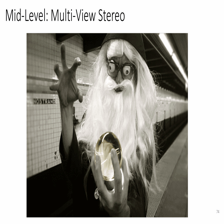

###################################################################
Question:  are there any limitations to using yolo and ssd for object detection?
Predicted Answer:  yes, if the parameter counts of yolo can vary in terms of computational efficiency, the confidence
Actual Answer:  some limitations of yolo include difficulties in detecting small objects due to spatial constraints, while ssd might struggle with a high class imbalance in dataset


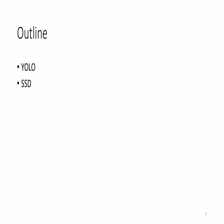

###################################################################
Question:  how does the presence of noise impact the accuracy of edge detection algorithms?
Predicted Answer:  the presence of noise can significantly affect the performance of edge detection algorithms by introducing spurious fluctuations in
Actual Answer:  the presence of noise can significantly impact the accuracy of edge detection algorithms by introducing false features and artifacts. noise can obscure true edges, leading to errors in


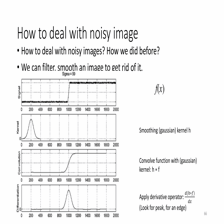

###################################################################
Question:  what challenges might arise when implementing scenario 1 of transfer learning?
Predicted Answer:  scenario 1 of transfer learning can be categorized based on the scenario where the model learns to learn more
Actual Answer:  challenges in implementing scenario 1 of transfer learning might include difficulties in tuning the final layers to effectively adapt to new tasks, potential mismatches between the feature


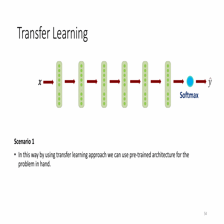

###################################################################
Question:  what is the operation mentioned in the transcript?
Predicted Answer:  the operation described in the transcript can be classified as a more effective operation in the context of the
Actual Answer:  the operation mentioned in the transcript is the removal of noise from an image.


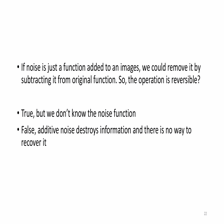

###################################################################
Question:  what is the purpose of applying the gradient threshold in keypoint localization?
Predicted Answer:  the purpose of applying the gradient orientation in the keypoint localization algorithm is to refine the
Actual Answer:  the gradient threshold is applied to filter out keypoints that do not meet a certain gradient criterion, helping to refine the selection of keypoints based on


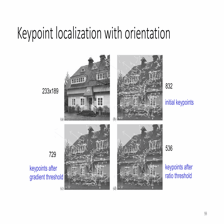

###################################################################
Question:  can you summarize the key steps and decision points involved in the bottom - up ( agglomerative ) clustering algorithm as explained?
Predicted Answer:  the bottom - up algorithm, as described in the transcript, involves the importance of clustering in
Actual Answer:  the bottom - up clustering algorithm starts with each item in its own cluster and iteratively merges pairs of clusters into new clusters, considering all


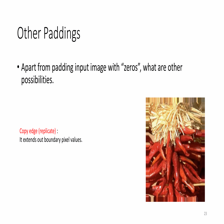

###################################################################
Question:  which image format supports animations and simple transitions?
Predicted Answer:  ascii graphics contribute to the effectiveness of gradient orientations in image representation by providing a more
Actual Answer:  gif ( graphics interchange format ) supports animations and simple transitions by allowing multiple frames within a single file. it is commonly used for web graphics,


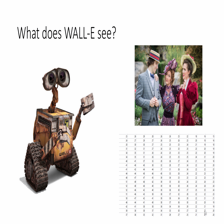

###################################################################
Question:  how might the use of an image pyramid enhance the performance of image classification algorithms?
Predicted Answer:  the inclusion of an image pyramid can contribute to improve performance by allowing the algorithm to leverage more detailed
Actual Answer:  image pyramids offer a hierarchical structure that allows image classifiers to analyze images at multiple scales, capturing both fine and coarse details. this enhances the


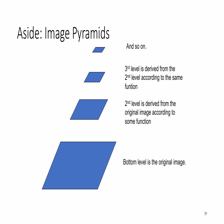

###################################################################
Question:  can you explain how machine learning techniques are applied in 3d animation?
Predicted Answer:  in machine learning, dimensionality reduction ( rnns ) is used for dimensionality reduction, where
Actual Answer:  machine learning techniques are applied in 3d animation for tasks such as character animation, motion capture, facial expression recognition, and generating realistic movement patterns, leveraging


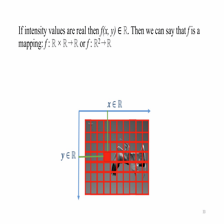

###################################################################
Question:  what is mentioned as a potential method for removing noisy from images?
Predicted Answer:  one alternative to the noisy function of a gaussian filter is the use of linear filters with
Actual Answer:  using a filter with a suppressor is mentioned as a potential method.


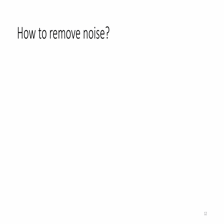

###################################################################
Question:  explain the concept of pixel categorization in threshold - based image processing.
Predicted Answer:  pixel response in thresholding involves the presence of gradient orientations in the image, where there is
Actual Answer:  pixel categorization in threshold - based image processing involves assigning pixels to specific values ( e. g., 0 or 255 ) based on whether


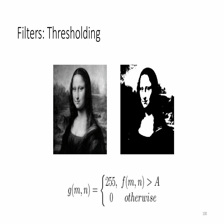

###################################################################
Question:  how does the test time per image with selective search compare between r - cnn and fast r - cnn?
Predicted Answer:  in faster r - cnn, the mean ap value ( r - cnn ) represents the average precision
Actual Answer:  with selective search, r - cnn takes 50 seconds per image, whereas fast r - cnn takes only 2 seconds per image.


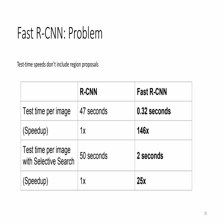

###################################################################
Question:  what is histogram equalization in image processing?
Predicted Answer:  in image processing, the histogram of gradient orientations can be categorized as a refine
Actual Answer:  histogram equalization in image processing is a technique used to enhance the contrast of an image by adjusting its intensity distribution. the process redistri


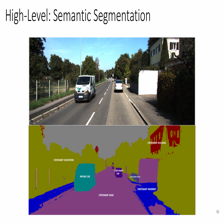

###################################################################
Question:  how is noise reduction described in the transcript?
Predicted Answer:  noise reduction techniques, as described in the transcript, are considered for the effectiveness of computer vision algorithms
Actual Answer:  the transcript describes noise reduction by suggesting the replacement of pixel values with their average.


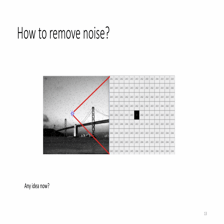

###################################################################
Question:  what concept in image processing does the discussion about scaling the operator relate to?
Predicted Answer:  the discussion emphasizes the importance of ensuring that the gradient magnitude in image processing contributes to the overall performance
Actual Answer:  the discussion about scaling the operator relates to the concept of normalization in image processing. normalization ensures that the values of the operator are adjusted to maintain


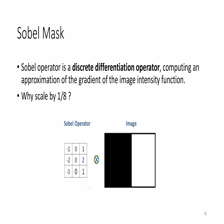

###################################################################
Question:  what is there in this slide?
Predicted Answer:  the " person / non - person distribution " of inferred from the invariance calculation
Actual Answer:  principal component analysis ( pca ) is a statistical technique used for dimensionality reduction and data visualization. by analyzing the variance and relationships between variables in


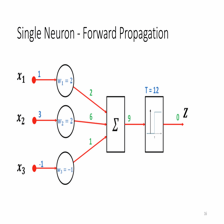

###################################################################
Question:  what is the role of contrast in digital images?
Predicted Answer:  the significance of contrast in digital images is that it influences the effectiveness of the r - cnn framework
Actual Answer:  the role of contrast in digital images is to define the range of brightness levels and the difference between light and dark areas. contrast affects the visual impact of


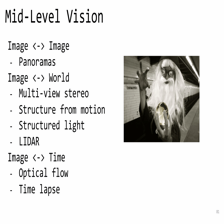

###################################################################
Question:  describe the steps to fine - tune a pre - trained network for a new classification task with a small dataset.
Predicted Answer:  to maximize the fine details of a pre - trained model, one would start by selecting a more
Actual Answer:  to fine - tune a pre - trained network for a new classification task with a small dataset, one should start by selecting a suitable pre - trained


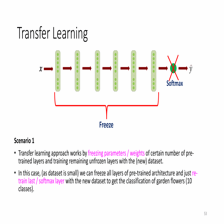

###################################################################
Question:  discuss the effectiveness of using a well - known cultural reference in the academic naming of a technological tool.
Predicted Answer:  the inclusion of a well - defined center pixel in a broader field of mathematical and computational resources can
Actual Answer:  using a well - known cultural reference, such as the movie ' inception ', in the academic naming of a technological tool like a neural network can be


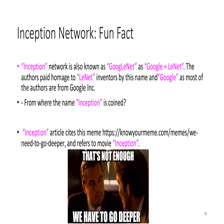

###################################################################
Question:  are we going to cover any specific algorithms in depth during this lecture?
Predicted Answer:  no, it may be challenging to consider the principles of parallel processing in the presence of more complex
Actual Answer:  today ' s lecture will likely go into depth on specific object detection algorithms, possibly covering advancements in models like yolo or faster r - cnn.


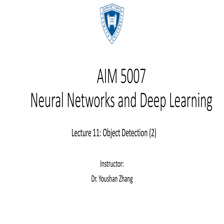

###################################################################
Question:  in what scenarios might the combination of box and class predictions be less accurate?
Predicted Answer:  typically, a more complex structure and a less scalability, such as the presence of gradient orientation
Actual Answer:  the combination might be less accurate in scenarios with heavy occlusion, similar - looking objects, or poor - quality images that make it difficult for yo


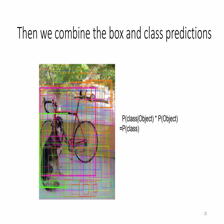

###################################################################
Question:  what is highlighted regarding the relationship between ' alpha ' and the resulting sharpening image?
Predicted Answer:  the conversation highlights the importance of parameter counts in the ' alpha ' of the gaussian function
Actual Answer:  the relationship between ' alpha ' and the resulting sharpening image is highlighted in terms of the direct influence of ' alpha ' on the degree of detail enhancement


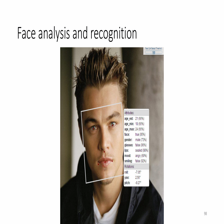

###################################################################
Question:  what is the role of the notion function as discussed in the transcript?
Predicted Answer:  the transcript emphasizes the importance of the linearity function in the r - cnn framework, where it
Actual Answer:  the transcript discusses the notion function in the context of gaussian functions and their approximation.


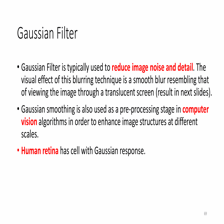

###################################################################
Question:  can you explain the differences between the various gradient kernels mentioned in the text?
Predicted Answer:  the text emphasizes that gradient magnitude can vary depending on the surrounding areas of the image, with different
Actual Answer:  the various gradient kernels mentioned in the text differ in their arrangement of weights, which determines how they compute the gradient of an image. for example,


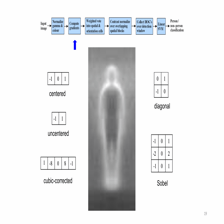

###################################################################
Question:  who is teaching lecture 7 on convolution neural networks in the aim 5007 course?
Predicted Answer:  dr. 1, specifically the lecture, focuses on convolutional neural networks ( con
Actual Answer:  dr. youshan zhang is the instructor teaching lecture 7 on convolution neural networks in the aim 5007 course.


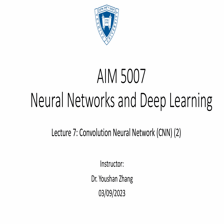

###################################################################
Question:  what is the significance of discussing edge detection in the next week?
Predicted Answer:  discussing edge detection in the context of the conversation may contribute to the broader context of the discussion,
Actual Answer:  discussing edge detection may provide insights into how it can be applied using simple image kernels.


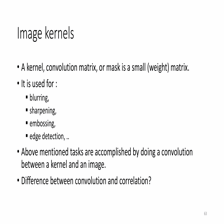

###################################################################
Question:  how does gaussian filtering differ from non - linear filtering in noise removal?
Predicted Answer:  non - linear filtering may involve noise reduction after gaussian filtering, where it may not be
Actual Answer:  gaussian filtering may not effectively remove noises that do not follow gaussian distribution, necessitating the use of non - linear filtering for such


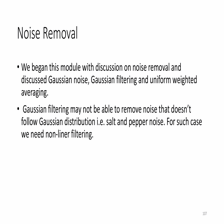

###################################################################
Question:  how does the roi pooling method shown improve model training?
Predicted Answer:  the roi pooling technique of roi pooling can be adapted by incorporating dropout layers within the
Actual Answer:  roi pooling streamlines the model training by ensuring that only the most relevant sections of an image are processed. by focusing on regions likely to contain objects


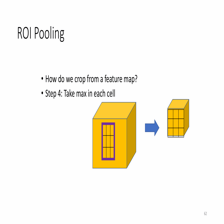

###################################################################
Question:  what are the technical requirements for implementing instance segmentation as shown in the urban scene?
Predicted Answer:  the technical considerations of the segmentation algorithm include the ability to define for specific tasks such as autonomous
Actual Answer:  technical requirements for implementing instance segmentation include robust algorithms capable of processing complex visual data, high computational power to handle real - time analysis, and sophisticated models


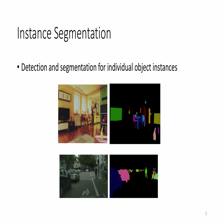

###################################################################
Question:  how does yolo divide the input image for processing?
Predicted Answer:  yolo assigns the parameter s in the gridding process to the input image, which may result
Actual Answer:  yolo divides the input image into an s x s grid for processing, with each grid cell responsible for predicting objects that fall within it.


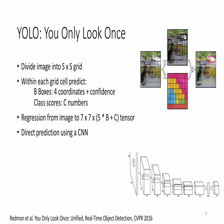

###################################################################
Question:  categorize the shift in technology from handcrafted features to convnets based on the imagenet results.
Predicted Answer:  the trend towards making the transition from convolutional layers to parameter sharing can be classified
Actual Answer:  the shift in technology from handcrafted features to convolutional neural networks ( convnets ) as depicted in the imagenet results can


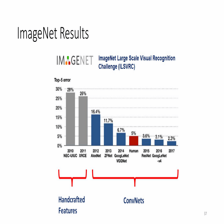

###################################################################
Question:  what is notable about median filtering compared to averaging?
Predicted Answer:  median filtering is preferred for effectively preserving image sharpness in the presence of noise reduction, as it
Actual Answer:  median filtering differs from averaging by selecting the median value, which helps in removing spikes and extreme values from the neighborhood.


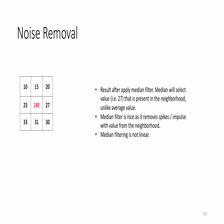

###################################################################
Question:  how are default boxes sorted in hard negative mining?
Predicted Answer:  in the ssd algorithm, orientations are considered beneficial for the model ' s ability to learn
Actual Answer:  default boxes are sorted by the highest confidence loss, which indicates the level of error in the model ' s predictions for each box.


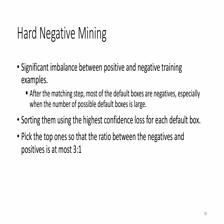

###################################################################
Question:  describe how roi pooling enhances object detection models.
Predicted Answer:  roi pooling enhances the robustness of r - cnn by ensuring that the region proposals accurately
Actual Answer:  roi pooling enhances object detection models by providing a mechanism to extract fixed - size feature vectors from variable - sized bounding boxes, ensuring that features


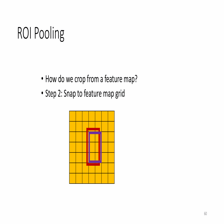

###################################################################
Question:  what does the parameter ' r ' signify in atrous convolution?
Predicted Answer:  in the r - cnn parameter ( atrous convolution ), the parameter ' r
Actual Answer:  in atrous convolution, the parameter ' r ' represents the rate or dilation factor, which determines the stride with which the input is


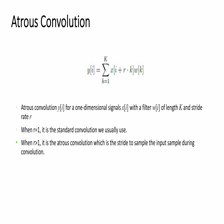

###################################################################
Question:  how does the transcript relate to the uav and its applications?
Predicted Answer:  the transcript emphasizes the importance of the trajectories in the gaussian composite, potentially
Actual Answer:  the transcript discusses the uav and its applications, providing insights into its role, tools, and ongoing research, particularly in detection and problem - solving.


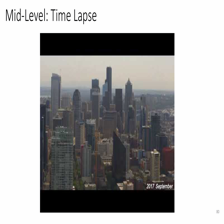

###################################################################
Question:  how would yolo use the confidence score p ( object ) in the context of this image?
Predicted Answer:  confidence score ( p ( object ) ) can be used to confidence in the presence of objects,
Actual Answer:  yolo would use the confidence score p ( object ) to quantify the likelihood that each predicted bounding box accurately contains an object. a higher score


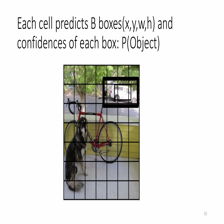

###################################################################
Question:  list the requirements for project two as described in the slide.
Predicted Answer:  the requirement for project two could be to build and train an n - flip model to effectively manipulate
Actual Answer:  the requirements for project two include building an object detection model using pytorch, training it with cow stall number datasets, evaluating the model


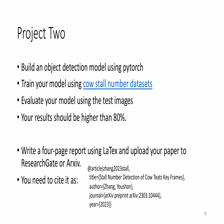

###################################################################
Question:  what is emphasized as very important for edges in the transcript?
Predicted Answer:  the transcript emphasizes the importance of gradient magnitude in the y - flip operation.
Actual Answer:  the transcript emphasizes that gradient magnitude is very important for edges.


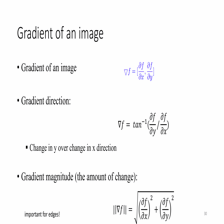

###################################################################
Question:  what is the role of algorithms in filtering?
Predicted Answer:  in computer vision algorithms, derivative filtering can be utilized to enhance the clarity of the gaussian
Actual Answer:  algorithms are applied to the values of pixels in the neighborhood of each input pixel to determine the value of the corresponding output pixel during filtering.


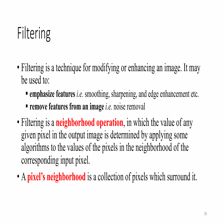

###################################################################
Question:  why does the precision decrease as recall increases in this graph?
Predicted Answer:  the precision complexity of the recall rate can be improved by reducing the computational costs associated with more accurate
Actual Answer:  precision decreases as recall increases because the model starts to include more potential true positives, increasing the risk of false positives. this trade - off is


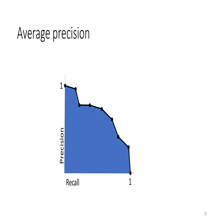

###################################################################
Question:  explain the key steps involved in the canny edge detection process as outlined in the transcript.
Predicted Answer:  the canny edge detection process involves several key steps, including the gradient magnitude, orientation, and
Actual Answer:  the transcript outlines the key steps of the canny edge detection process. firstly, the image is convolved with the derivative of gaussian filter


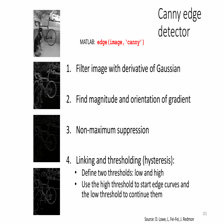

###################################################################
Question:  what is the concept of a ' half plane ' discussed in the transcript?
Predicted Answer:  the ' half plane ' is considered a fundamental concept in the context of machine learning, where it
Actual Answer:  the concept of a ' half plane ' refers to a space whose dimension is one less than the ambient space. for example, in a 2d space,


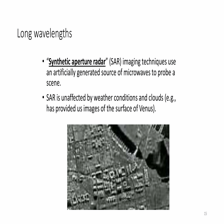

###################################################################
Question:  what is the significance of image addition in digital image processing?
Predicted Answer:  the significance of image gradient calculation in digital image processing is to provide the framework for refining and enhancing
Actual Answer:  the significance of image addition in digital image processing is that it allows for combining pixel values from two or more images to create a new image. this operation


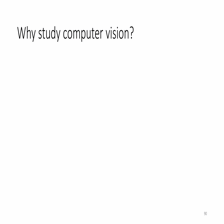

###################################################################
Question:  what is the size of the matrix mentioned in the transcript?
Predicted Answer:  the transcript emphasizes the importance of the matrix m in the context of the mathematical algorithm.
Actual Answer:  the size of the matrix mentioned in the transcript is specified as ' 3 by 3, ' indicating a matrix with 3 rows and 3 columns.


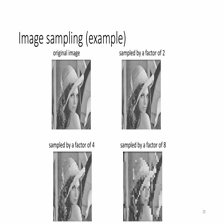

###################################################################
Question:  what are some common applications of vector space scaling?
Predicted Answer:  vector space exploration can be applied in areas such as dimensionality reduction, dimensionality reduction, and
Actual Answer:  vector space scaling is used in various applications such as principal component analysis ( pca ), spectral clustering, feature scaling in machine learning, and geometric


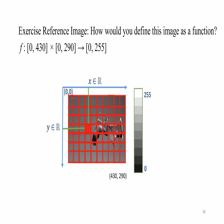

###################################################################
Question:  how does the transcript exemplify the application of visual perception in computational tasks?
Predicted Answer:  the transcript suggests improving the overall functionality of vision transformers in the r - cnn framework by incorporating context
Actual Answer:  this demonstrates the application of visual perception in computational tasks through the participants ' engagement in identifying directional features, showcasing the integration of human perception with machine analysis.


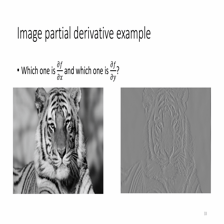

###################################################################
Question:  what is the significance of identifying stable features across multiple scales in scale - space extrema detection?
Predicted Answer:  considering the scale space of the gaussian function helps in understanding the stable features of the scale
Actual Answer:  identifying stable features across multiple scales is significant as it allows for the detection of keypoints that are robust to changes in viewpoint, scale, and illumination,


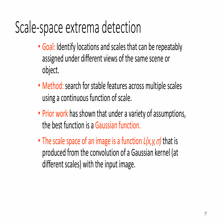

###################################################################
Question:  explain what the graph on this slide represents.
Predicted Answer:  the graph can be classified as a more complex one, where the slope transitions in the first derivative
Actual Answer:  the graph shows the mean average precision ( ap ) scores for different versions of the r - cnn family of object detection models. it traces improvements from r


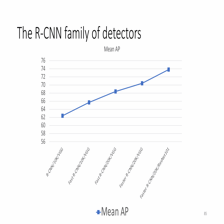

###################################################################
Question:  why is similarity considered hard to define, according to the context?
Predicted Answer:  difficulty is considered beneficial for the effectiveness of transfer learning if it requires the inherent properties of the data
Actual Answer:  similarity is considered hard to define because it can be subjective and context - dependent. however, the context suggests that despite this difficulty, people often intuitively


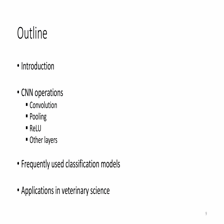

###################################################################
Question:  how does an unsharp mask affect the contrast of an image?
Predicted Answer:  an unsharp mask can contribute to the overall anew of the vision transformer, as
Actual Answer:  an unsharp mask affects the contrast of an image by emphasizing the differences between the original and the blurred version. this technique creates a mask that,


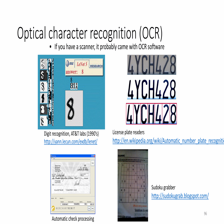

###################################################################
Question:  what does the softmax layer do in this convnet?
Predicted Answer:  the softmax layer in the convnet to be utilized in the vision transformer can help
Actual Answer:  the softmax layer in this convnet takes the outputs from the last fully connected layer ( fc4 ) and converts them into probability scores representing the


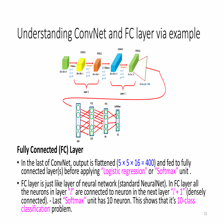

###################################################################
Question:  what are the main components of the image gradient computation process as outlined in the text?
Predicted Answer:  the main components of the gradient magnitude ( h ) can include the magnitude and orientation of the gradient
Actual Answer:  the text outlines the process of computing the image gradient, which involves kernel convolution to determine both magnitude and angle components. the magnitude represents the


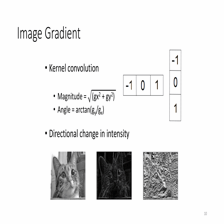

###################################################################
Question:  how does the course emphasize the importance of projects versus homework?
Predicted Answer:  the course prepares the academic community by providing a course overview on the subject matter, specifically through the
Actual Answer:  the course places a stronger emphasis on projects, which make up 70 % of the final grade ( 40 % for three projects and 30 % for the final


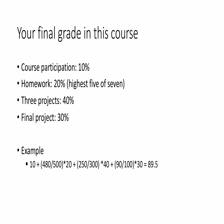

###################################################################
Question:  how does vector manipulation contribute to spectral clustering algorithms?
Predicted Answer:  vector manipulation contributes to the interpretation of euclidean distance thresholding algorithms by providing a consistent framework for determining
Actual Answer:  in spectral clustering algorithms, vector manipulation techniques such as scaling and normalization are employed to preprocess data and construct similarity matrices, enabling the


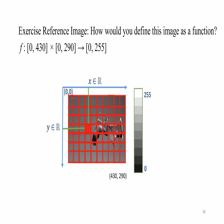

###################################################################
Question:  what challenges or considerations might be associated with the segmentation of white matter or gray matter mentioned in the transcript?
Predicted Answer:  in the context of segmentation, challenges in understanding white matter or gray matter can include the potential
Actual Answer:  the transcript introduces the segmentation of white matter or gray matter, and exploring potential challenges or considerations associated with this process can provide a more comprehensive understanding of


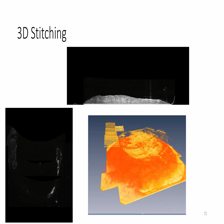

###################################################################
Question:  what is there in this slide?
Predicted Answer:  the " person / non - person distribution " of inferred from the invariance calculation
Actual Answer:  various distance or similarity measures offer alternative ways to quantify dissimilarity or similarity between data instances. one such measure is the minkowski metric


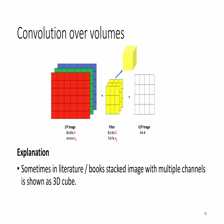

###################################################################
Question:  how are the concepts discussed related to the dimensions of space?
Predicted Answer:  the principles of euclidean spaces, such as convolutional layers, can be categorized into
Actual Answer:  the concepts discussed in the transcript are related to the dimensions of space, particularly in cases involving 2d or 3d space. the dimensions play a crucial role in


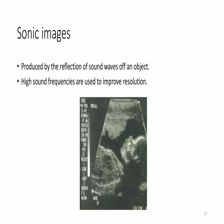

###################################################################
Question:  what does the speaker suggest about the outcome of ' trying to improve ' the image?
Predicted Answer:  the speaker suggests considering the importance of maintaining consistent as the gradient of the image becomes different from the
Actual Answer:  the speaker suggests that attempting to improve the image through processing will result in a noticeable change or enhancement.


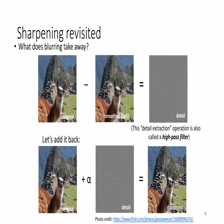

###################################################################
Question:  what is recommended to achieve the proposed solution?
Predicted Answer:  to enhance the effectiveness of the proposed approach, strategies such as incorporating gradient magnitudes, parallel processing
Actual Answer:  to achieve the proposed solution, it is recommended to have higher values in the center and lower values at the edges.


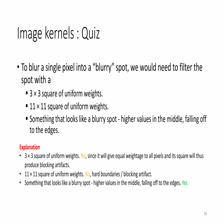

###################################################################
Question:  what future developments might improve the performance of mdp - based helicopter control?
Predicted Answer:  advancements could include the potential for improved performance, improved accuracy in computational resources, and the potential
Actual Answer:  future developments might include integrating more advanced machine learning techniques to better predict state transitions, enhancing sensor technologies for more accurate data, and developing more sophisticated noise models


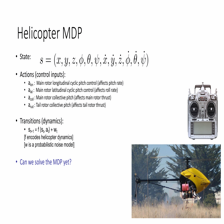

###################################################################
Question:  create a fictional scenario describing a student ' s confusion about the function ' g ' and a teacher clarifying it.
Predicted Answer:  in a bustling university degree, a student, armed with her understanding of the course, armed
Actual Answer:  a student, puzzled about the ' g ' function in the residual block diagram, asks, ' does ' g ' modify the input data directly? '


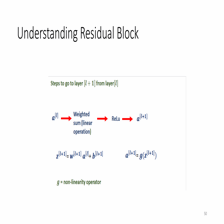

###################################################################
Question:  how does the result ' inferred sequence is much cleaner ' relate to the objectives of trajectory analysis?
Predicted Answer:  the outcome of the outcome in transfer learning can be classified as a more effective and effective approach to
Actual Answer:  the cleaner inferred sequence indicates a successful alignment of noisy or varied data into a more coherent and consistent trajectory, which is crucial for understanding the underlying


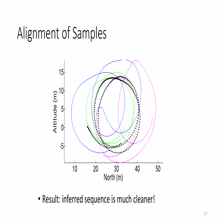

###################################################################
Question:  what are some potential strategies to enhance the performance of recommender systems given the sparse nature of user / item matrices?
Predicted Answer:  strategies could include user interaction methods, the ability of user interaction strategies, and the ability to engage
Actual Answer:  potential strategies include incorporating additional user and item features, utilizing hybrid recommendation approaches, implementing matrix factorization techniques, and leveraging contextual information to make more


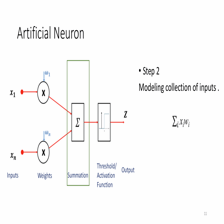

###################################################################
Question:  can you provide more details about the image mentioned in the context?
Predicted Answer:  the image illustrates the convnet configuration of the r - cnn framework, with its emphasis on
Actual Answer:  the image features both a dog and a woman with the same hairstyle, serving as an example of similarity within the context of clustering.


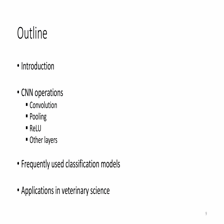

###################################################################
Question:  what are some examples of masks discussed in the lecture?
Predicted Answer:  the mask structures, particularly in the context of the convnet, can be categorized into two
Actual Answer:  the lecture discusses various masks, including sobel and prewitt masks, for edge detection. these masks are designed for x and y directions to capture


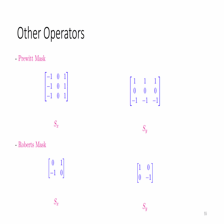

###################################################################
Question:  can you provide an analogy to illustrate the concept of the hysteresis threshold in edge detection?
Predicted Answer:  imagine an edge detector as a simple image processing technique, where the gradient magnitude and orientation are assigned
Actual Answer:  imagine a team of detectives investigating a crime scene. each detective specializes in identifying specific types of evidence, with some focused on strong clues and others on subtle


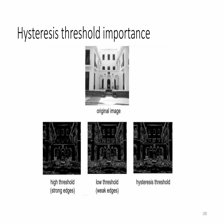

###################################################################
Question:  what components are mentioned in relation to the x - flip operation?
Predicted Answer:  the " x - flip " operation involves iteratively merging the data points in the horizontal or
Actual Answer:  h1, h2, and h3 are mentioned in relation to the x - flip operation.


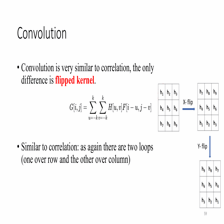

###################################################################
Question:  what are some purposes of filtering?
Predicted Answer:  filtering can be beneficial in the context of an n - flip operation because it allows the network to
Actual Answer:  filtering can be used to emphasize features such as motion sharpening and edge enhancement, as well as to remove features like noise.


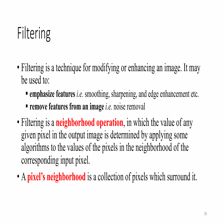

###################################################################
Question:  discuss the impact of residual connections on the training dynamics of vision transformers.
Predicted Answer:  adaptability in the vision transformer could lead to more robust and complex training in the network,
Actual Answer:  residual connections impact the training dynamics of vision transformers by ensuring that the learning signals can be effectively propagated back through the network, even across many layers


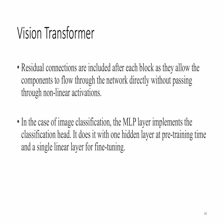

###################################################################
Question:  what key points are highlighted in the transcript regarding image processing and operations?
Predicted Answer:  the transcript highlights the importance of overall understanding the key components of the image interpretation, contrasting effects,
Actual Answer:  the transcript highlights key discussions on image processing, operations, contrasting effects, and potential outcomes.


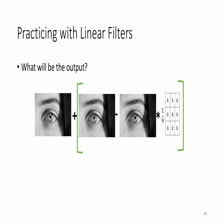

###################################################################
Question:  what technique was suggested instead of using the average of pixel values in the neighborhood?
Predicted Answer:  in the broader field of computer vision, the use of gradient magnitude instead of treating nearby pixels differently
Actual Answer:  using the median value of pixel values in the neighborhood was suggested as an alternative to using the average.


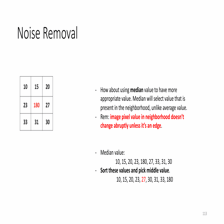

###################################################################
Question:  what does the transcript suggest about the recoverability of the original image?
Predicted Answer:  the transcript suggests that even if the function of eta is known and the entire image is revers
Actual Answer:  the transcript suggests that even if the function of eta is known, the original image may still not be recoverable because additive noise may destroy the information.


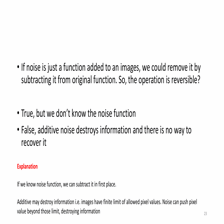

###################################################################
Question:  what is the difference between batch normalization and dropout in neural networks?
Predicted Answer:  the inclusion of normalization criteria in the stochastic gradient descent, particularly in the clustering
Actual Answer:  batch normalization helps stabilize neural network training by normalizing inputs to layers. dropout is a regularization technique that involves randomly dropping out neurons during training


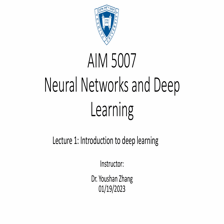

###################################################################
Question:  how is noise removal described in the transcript?
Predicted Answer:  noise reduction techniques can be categorized as a method for improving the performance of noise removal in the presence
Actual Answer:  the transcript describes noise removal by averaging pixel values.


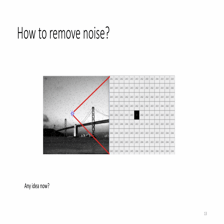

###################################################################
Question:  what is there in this slide?
Predicted Answer:  the " person / non - person distribution " of inferred from the invariance calculation
Actual Answer:  in this overview of machine learning concepts, we explore various methods for matrix factorization. we start with the motivation behind matrix factorization techniques, highlighting their


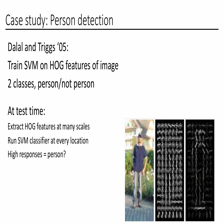

###################################################################
Question:  describe the input and output relationship in segnet.
Predicted Answer:  in the initial setup of eigenvalue decomposition, the encoder setup becomes more effective
Actual Answer:  in segnet, the input is a standard rgb image, and the output is a segmentation map where each pixel is classified into one of


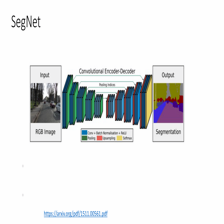

###################################################################
Question:  what are the implications of a large positive covariance between two dimensions?
Predicted Answer:  a two - dimensional subspace can lead to increased complexity in the discussion, as it can lead
Actual Answer:  a large positive covariance suggests that the two dimensions tend to increase or decrease together, indicating a positive relationship between them.


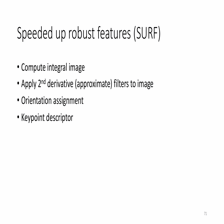

###################################################################
Question:  what role does the laplacian operator play in zero crossing detection?
Predicted Answer:  the laplacian operator in zero crossing can be utilized in the context of the laplacian
Actual Answer:  the laplacian operator is used to compute the second derivative of the image, highlighting areas of rapid intensity change or gradient discontinuities. by


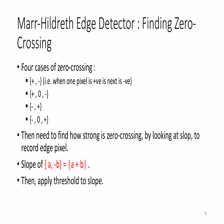

###################################################################
Question:  what term is used to describe the process of looping over all pixels in the neighborhood?
Predicted Answer:  the term ' looping over all pixels in the neighborhood ' is used to describe the process of
Actual Answer:  the term ' looping over all pixels in the neighborhood ' is used to describe the process discussed in the transcript.


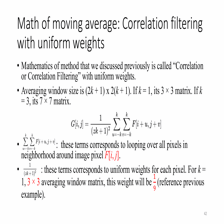

###################################################################
Question:  how is the reward function structured for helicopter hovering?
Predicted Answer:  the reward function ( f ), or trace calculation, is used to evaluate the reward function,
Actual Answer:  the reward function is structured as a series of penalties for deviation from desired spatial coordinates ( x, y, z ) and excessive velocities (


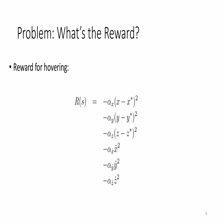

###################################################################
Question:  generate a metaphor to explain the role of the region proposal network in faster r - cnn.
Predicted Answer:  imagine the scenario where faster r - cnn can be trained by the vast expanse of an image,
Actual Answer:  the region proposal network ( rpn ) in faster r - cnn acts like a scout. just as a scout surveys the terrain and identifies key areas


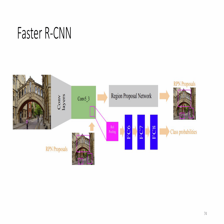

###################################################################
Question:  how important is image quality in the detection procedure for accurate results?
Predicted Answer:  the importance of image gradient magnitude in the quality of the proposed region proposal generation algorithm is crucial for
Actual Answer:  image quality is very important ; higher resolution and clear imagery can greatly improve the accuracy of the detection, especially for fine details and small or distant objects.


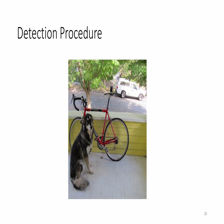

###################################################################
Question:  how do the visual aids on the slide help in understanding the effect of relu on 1x1 convolution outputs?
Predicted Answer:  the visual cues such as 1x1 convolution, which are crucial for improving the
Actual Answer:  the visual aids on the slide help by showing the before and after effects of applying relu to the outputs from 1x1 convolutions.


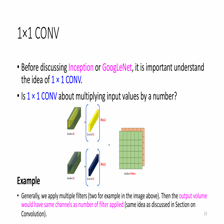

###################################################################
Question:  what advice is provided regarding the proposed solution?
Predicted Answer:  the objective proposed is to minimize the squared differences between the observed entries of the given dataset,
Actual Answer:  the advice given is to have higher values in the center and lower values towards the edges in the proposed solution.


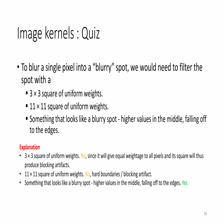

###################################################################
Question:  how does a threshold filter contribute to image segmentation?
Predicted Answer:  a threshold filter contributes to the interpretation of image segmentation by providing a straightforward method to catego
Actual Answer:  a threshold filter simplifies image segmentation by converting grayscale images into binary outputs, facilitating the isolation of objects or features based on prede


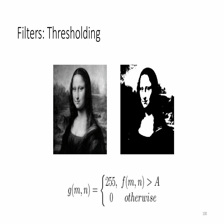

###################################################################
Question:  what is caution filtering and when may it not effectively remove noise?
Predicted Answer:  gradient orientation can affect detection in unsupervised learning, as it can lead to more
Actual Answer:  caution filtering is a method used to remove noise in images, but it may not be effective if there are significant amounts of noise present, particularly thousands of


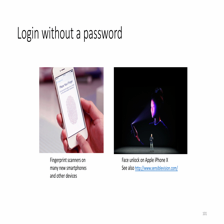

###################################################################
Question:  how does canny ' s method utilize gradient direction to inform edge detection?
Predicted Answer:  canny edge detection ( canny edge detection ) can contribute to the effectiveness of invariance
Actual Answer:  canny ' s method utilizes gradient direction to inform edge detection by examining patterns in neighborhood pixels. the gradient direction, also known as the direction of the


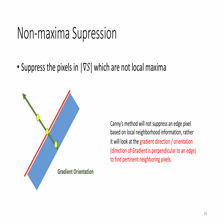

###################################################################
Question:  what is the function of pixelwise output and loss in the network?
Predicted Answer:  pixel response reduction in the inception module may influence its overall performance by reducing the number of parameters and
Actual Answer:  pixelwise output ensures that each pixel in the input image is classified into a category, making it suitable for segmentation tasks. the loss function measures the


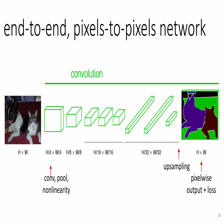

###################################################################
Question:  brainstorm potential collaborations between image processing experts and practitioners from other fields to explore novel applications of image kernels.
Predicted Answer:  consider applications in image processing, particularly in fields such as computer vision, image analysis, and data
Actual Answer:  consider interdisciplinary collaborations with professionals from fields such as healthcare, environmental science, architecture, and entertainment.


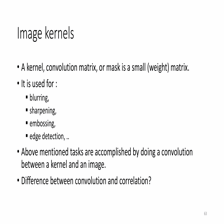

###################################################################
Question:  what is the primary objective of clustering as described in the context?
Predicted Answer:  the primary objective of transfer learning as described in the transcript is to minimize the spread of gradient magnitude
Actual Answer:  the primary objective of clustering is to find clusters within a set of data points, maximizing inter - cluster similarity while minimizing intra - cluster


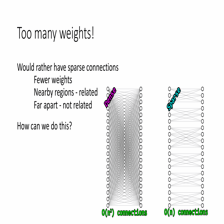

###################################################################
Question:  what term does the speaker use to describe the behavior of the blue line?
Predicted Answer:  the speaker describes the behavior of the blue line as uniform.
Actual Answer:  the speaker describes the behavior of the blue line as uniform.


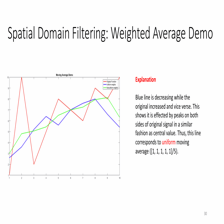

###################################################################
Question:  can you explain how the equation b * = arg min b st. rank ( b ) = k | | xb | | relates to dimensional
Predicted Answer:  it demonstrates the importance of dimensionality reduction in matrix x by representing the original matrix x with a
Actual Answer:  it represents the process of reducing the dimensionality of the data by approximating the original matrix x with a lower - rank matrix b *.


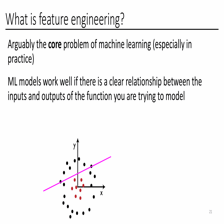

###################################################################
Question:  what is the role of the dense layers in vgg - 16?
Predicted Answer:  the dense layers in the fcn architecture may serve as a non - linear framework for dimensionality
Actual Answer:  the dense layers in vgg - 16, located at the end of the network, are responsible for making the final decisions. after receiving processed features from


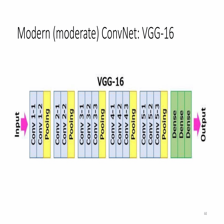

###################################################################
Question:  what role does visible light play in human vision?
Predicted Answer:  human vision significantly influences the interpretation of vision transformer by providing a broader range of colors for the
Actual Answer:  visible light plays a fundamental role in human vision as it enables the human eye to detect and perceive the surrounding environment. by interacting with photorecept


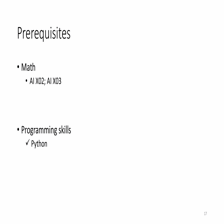

###################################################################


In [40]:
for x in range(100):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")

In [41]:
import torch
from torch.nn.functional import normalize

def cosine_similarity(tensor1, tensor2):
    """
    Compute the cosine similarity between two tensors.
    """
    tensor1_normalized = normalize(tensor1, p=2, dim=-1)
    tensor2_normalized = normalize(tensor2, p=2, dim=-1)
    return (tensor1_normalized * tensor2_normalized).sum(dim=-1)


In [42]:
from tqdm.notebook import tqdm

cosine_similarities = []

# Assuming 'test_dataloader' is defined similarly to your 'val_dataloader'
for batch in tqdm(val_dataloader):
    sample = {k: v.to(device) for k, v in batch.items()}

    # Forward pass to generate outputs
    outputs = model.generate(
        input_ids=sample['input_ids'],
        pixel_values=sample['pixel_values'],
        attention_mask=sample['attention_mask'],
        max_length=sample['labels'].size(1)  # Ensure generated length matches labels length
    )

    # Assuming outputs are in the same device as labels
    # Here, labels and outputs are both tensors of token IDs
    labels = sample['labels']

    # Convert token IDs to embeddings or another form suitable for cosine similarity
    # This step is skipped in this example for simplicity

    # Compute cosine similarity for each item in the batch
    for idx in range(outputs.size(0)):
        cos_sim = cosine_similarity(outputs[idx].unsqueeze(0).float(), labels[idx].unsqueeze(0).float())
        cosine_similarities.append(cos_sim.item())

# Display the computed similarities
print("Cosine Similarities:", cosine_similarities)


  0%|          | 0/135 [00:00<?, ?it/s]

Cosine Similarities: [0.7783362865447998, 0.23101913928985596, 0.39778751134872437, 0.5051330327987671, 0.47259995341300964, 0.3733079433441162, 0.5702769756317139, 0.43758994340896606, 0.5860536694526672, 0.32573628425598145, 0.3562718629837036, 0.5136798620223999, 0.42248156666755676, 0.3646793067455292, 0.3576761782169342, 0.37923485040664673, 0.22816935181617737, 0.47464442253112793, 0.2817428410053253, 0.4781249165534973, 0.3829132914543152, 0.3894962668418884, 0.502875566482544, 0.30591702461242676, 0.47407373785972595, 0.30552995204925537, 0.31255340576171875, 0.2865092158317566, 0.3268367648124695, 0.44500237703323364, 0.547032356262207, 0.8883271813392639, 0.4101485013961792, 0.3638429641723633, 0.38238805532455444, 0.4551272392272949, 0.5064108967781067, 0.3244587779045105, 0.6171190738677979, 0.7518548965454102, 0.6622478365898132, 0.4054925739765167, 0.48578739166259766, 0.6308939456939697, 0.5049483776092529, 0.4850032329559326, 0.306762158870697, 0.30484214425086975, 0.36

In [43]:
# Calculate the average of the cosine similarity scores
avg_cosine_similarity = np.mean(cosine_similarities)

# Print the average cosine similarity
print("Average Cosine Similarity on Test Data:", avg_cosine_similarity)


Average Cosine Similarity on Test Data: 0.42131694960752847


In [44]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


In [45]:
# Prepare your data and model
# Assuming test_dataloader is already defined and model is loaded

# Store all the candidate and reference sentences
candidates = []
references = []

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model.generate(**inputs)

        # Decode the output indices to strings
        generated_texts = [text_processor.decode(g, skip_special_tokens=True) for g in outputs]
        actual_texts = [text_processor.decode(l, skip_special_tokens=True) for l in batch['labels']]

        # Add the generated and actual texts to their respective lists
        candidates.extend([[tok for tok in gen.split()] for gen in generated_texts])
        references.extend([[[tok for tok in act.split()]] for act in actual_texts])  # Note the double list for references

# Calculate BLEU score
chencherry = SmoothingFunction()
score = corpus_bleu(references, candidates, smoothing_function=chencherry.method1)

print(f"BLEU score: {score}")


  0%|          | 0/135 [00:00<?, ?it/s]

BLEU score: 0.1207424603467558


In [46]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [47]:
pip install rouge-score


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=4295aafc8bfc33152a35eb722c6d4bea7416a81aabd18227283e96313917a3f4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [48]:
from rouge_score import rouge_scorer
from tqdm.notebook import tqdm

# Prepare your data and model
# Assuming test_dataloader is already defined and model is loaded

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Lists to store all scores
scores_rouge1 = []
scores_rouge2 = []
scores_rougeL = []

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model.generate(**inputs)

        # Decode the output indices to strings
        generated_texts = [text_processor.decode(g, skip_special_tokens=True) for g in outputs]
        actual_texts = [text_processor.decode(l, skip_special_tokens=True) for l in batch['labels']]

        # Calculate ROUGE scores for each pair of generated and actual text
        for gen_text, act_text in zip(generated_texts, actual_texts):
            score = scorer.score(act_text, gen_text)
            scores_rouge1.append(score['rouge1'].fmeasure)
            scores_rouge2.append(score['rouge2'].fmeasure)
            scores_rougeL.append(score['rougeL'].fmeasure)

# Calculate average scores
avg_rouge1 = sum(scores_rouge1) / len(scores_rouge1)
avg_rouge2 = sum(scores_rouge2) / len(scores_rouge2)
avg_rougeL = sum(scores_rougeL) / len(scores_rougeL)

print(f"Average ROUGE-1 score: {avg_rouge1}")
print(f"Average ROUGE-2 score: {avg_rouge2}")
print(f"Average ROUGE-L score: {avg_rougeL}")


  0%|          | 0/135 [00:00<?, ?it/s]

Average ROUGE-1 score: 0.3934766233261068
Average ROUGE-2 score: 0.19137810015946677
Average ROUGE-L score: 0.34126152567275125
